In [1]:
import pyspark

In [2]:
from pyspark import SparkContext, SparkConf

In [3]:
!hdfs dfsadmin -safemode leave

2023-11-30 15:13:34 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Safe mode is OFF


In [4]:
conf = SparkConf().set("spark.executor.instances", "2").set("spark.executor.cores", "1").set("spark.executor.memory", "1g")

In [5]:
sc = SparkContext(appName="pyspark_rdd", master="yarn")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/30 15:13:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/30 15:13:40 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


# RDD

## Как создать RDD?

### 1. Распределить коллекцию с драйвера

In [6]:
import numpy as np

In [29]:
vocabulary = ["Apache", "Spark", "Hadoop"]
numbers = np.random.randint(10, size=10000)
words = np.random.choice(vocabulary, size=10000)
collection = zip(numbers, words)

In [30]:
rdd = sc.parallelize(collection)

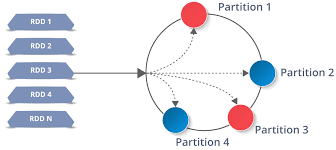

In [31]:
rdd

ParallelCollectionRDD[10] at readRDDFromFile at PythonRDD.scala:289

In [32]:
rdd.count()

10000

In [33]:
rdd.getNumPartitions()

2

In [34]:
rdd.take(7000)

[(6, 'Hadoop'),
 (9, 'Apache'),
 (3, 'Hadoop'),
 (1, 'Hadoop'),
 (1, 'Spark'),
 (1, 'Hadoop'),
 (0, 'Spark'),
 (7, 'Apache'),
 (3, 'Spark'),
 (5, 'Hadoop'),
 (1, 'Spark'),
 (6, 'Apache'),
 (4, 'Apache'),
 (8, 'Hadoop'),
 (4, 'Spark'),
 (6, 'Spark'),
 (1, 'Apache'),
 (9, 'Hadoop'),
 (0, 'Spark'),
 (5, 'Spark'),
 (8, 'Hadoop'),
 (0, 'Spark'),
 (9, 'Hadoop'),
 (0, 'Spark'),
 (4, 'Hadoop'),
 (3, 'Hadoop'),
 (9, 'Spark'),
 (2, 'Spark'),
 (4, 'Apache'),
 (4, 'Hadoop'),
 (5, 'Spark'),
 (4, 'Apache'),
 (0, 'Apache'),
 (7, 'Spark'),
 (2, 'Apache'),
 (8, 'Hadoop'),
 (0, 'Spark'),
 (1, 'Hadoop'),
 (4, 'Hadoop'),
 (0, 'Hadoop'),
 (1, 'Hadoop'),
 (0, 'Spark'),
 (8, 'Apache'),
 (0, 'Apache'),
 (0, 'Hadoop'),
 (8, 'Spark'),
 (3, 'Apache'),
 (0, 'Hadoop'),
 (1, 'Hadoop'),
 (0, 'Spark'),
 (1, 'Spark'),
 (8, 'Apache'),
 (9, 'Apache'),
 (5, 'Hadoop'),
 (1, 'Apache'),
 (6, 'Apache'),
 (9, 'Hadoop'),
 (0, 'Hadoop'),
 (4, 'Hadoop'),
 (9, 'Spark'),
 (7, 'Hadoop'),
 (8, 'Spark'),
 (3, 'Hadoop'),
 (5, 'Hadoop'

#### Единицей вычислений в спарке выступает партиция

In [35]:
sc.parallelize(range(10)).take(9)

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [16]:
sc.parallelize(range(10)).glom().collect()

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]

In [12]:
rdd.getNumPartitions()

2

### 2. Загрузить внешний датасет (датасет загружается из hdfs)

In [10]:
!hdfs dfs -rm -r ml-latest-small

2023-11-30 15:16:02 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `ml-latest-small': No such file or directory


In [11]:
!hdfs dfs -put ml-latest-small .

2023-11-30 15:16:04 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [38]:
rdd_ratings = sc.textFile("ml-latest-small/ratings.csv")

In [39]:
rdd_ratings.take(10)

['userId,movieId,rating,timestamp',
 '1,1,4.0,964982703',
 '1,3,4.0,964981247',
 '1,6,4.0,964982224',
 '1,47,5.0,964983815',
 '1,50,5.0,964982931',
 '1,70,3.0,964982400',
 '1,101,5.0,964980868',
 '1,110,4.0,964982176',
 '1,151,5.0,964984041']

## RDD API состоит из операций двух видов: 
* transformation (filter, map, groupBy, repartition, cache, ...)
* action (take, count, collect, ...)

## 1.Трансформации 
### преобразовывают RDD в другой RDD и не триггерят вычисление графа (ленивость вычислений)

#### Трансформации можно применять одну за другой пока не будет вызван action

In [40]:
rdd = sc.parallelize(range(100))

In [41]:
rdd2 = rdd.filter(lambda x: x % 2)

In [42]:
rdd2

PythonRDD[21] at RDD at PythonRDD.scala:53

In [44]:
rdd3 = rdd2.map(lambda x: x * 2)

In [45]:
rdd4 = rdd3.map(lambda x: x + 100)

In [46]:
rdd4.take(5)

[102, 106, 110, 114, 118]

### Action заставляет Spark вычислить граф и вернуть результат либо на драйвер либо во внешнее хранилище и таким образом триггерит job-у в спарке

In [47]:
# забирает все на драйвер
rdd4.collect()

[102,
 106,
 110,
 114,
 118,
 122,
 126,
 130,
 134,
 138,
 142,
 146,
 150,
 154,
 158,
 162,
 166,
 170,
 174,
 178,
 182,
 186,
 190,
 194,
 198,
 202,
 206,
 210,
 214,
 218,
 222,
 226,
 230,
 234,
 238,
 242,
 246,
 250,
 254,
 258,
 262,
 266,
 270,
 274,
 278,
 282,
 286,
 290,
 294,
 298]

In [48]:
rdd4.getNumPartitions()

2

### Во время вычисления job-ы вычисляются task-и - вычисления над нашими партициями
* сколько партиций, столько и тасок
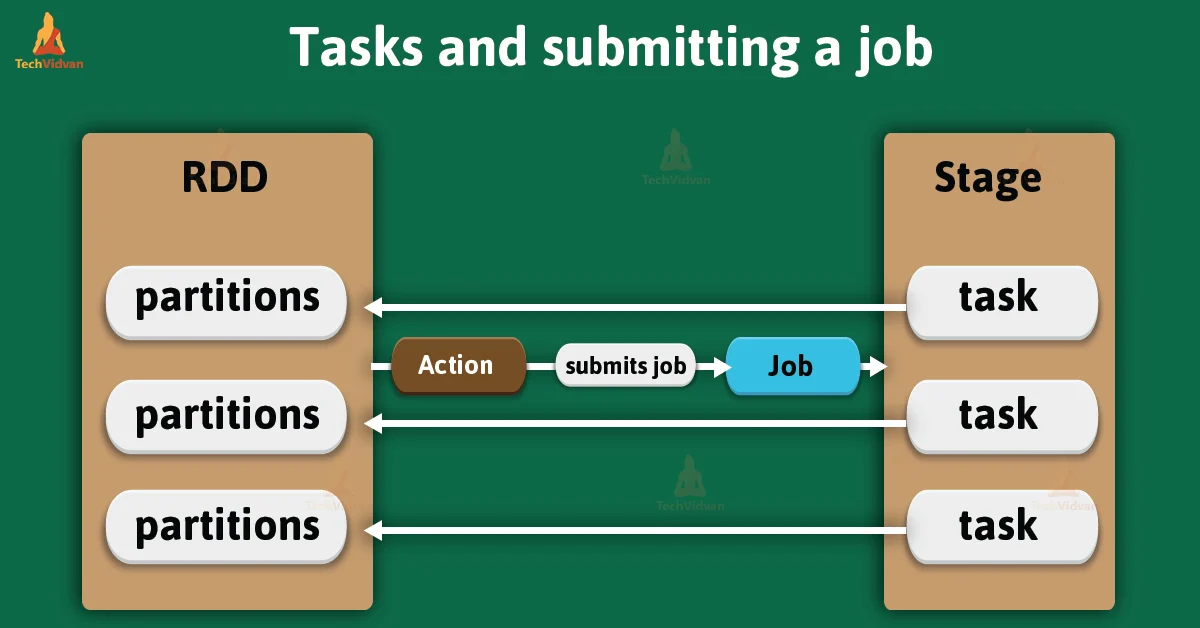

In [49]:
!hdfs dfs -rm -r numbers

2023-11-22 19:06:15 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Deleted numbers


In [50]:
# записывает в хранилище
rdd4.saveAsTextFile("numbers")

In [51]:
!hdfs dfs -ls numbers

2023-11-22 19:06:39 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 3 items
-rw-r--r--   3 root supergroup          0 2023-11-22 19:06 numbers/_SUCCESS
-rw-r--r--   3 root supergroup        100 2023-11-22 19:06 numbers/part-00000
-rw-r--r--   3 root supergroup        100 2023-11-22 19:06 numbers/part-00001


### Трансформации бывают узкие и широкие
* узкие трансформации происзводятся на своих партициях без пересылки данных между экзекьюторами без shuffle-а
* широкие же происзводятся с пересылкой данных между экзекьюторами, что приводит к shuffle-у

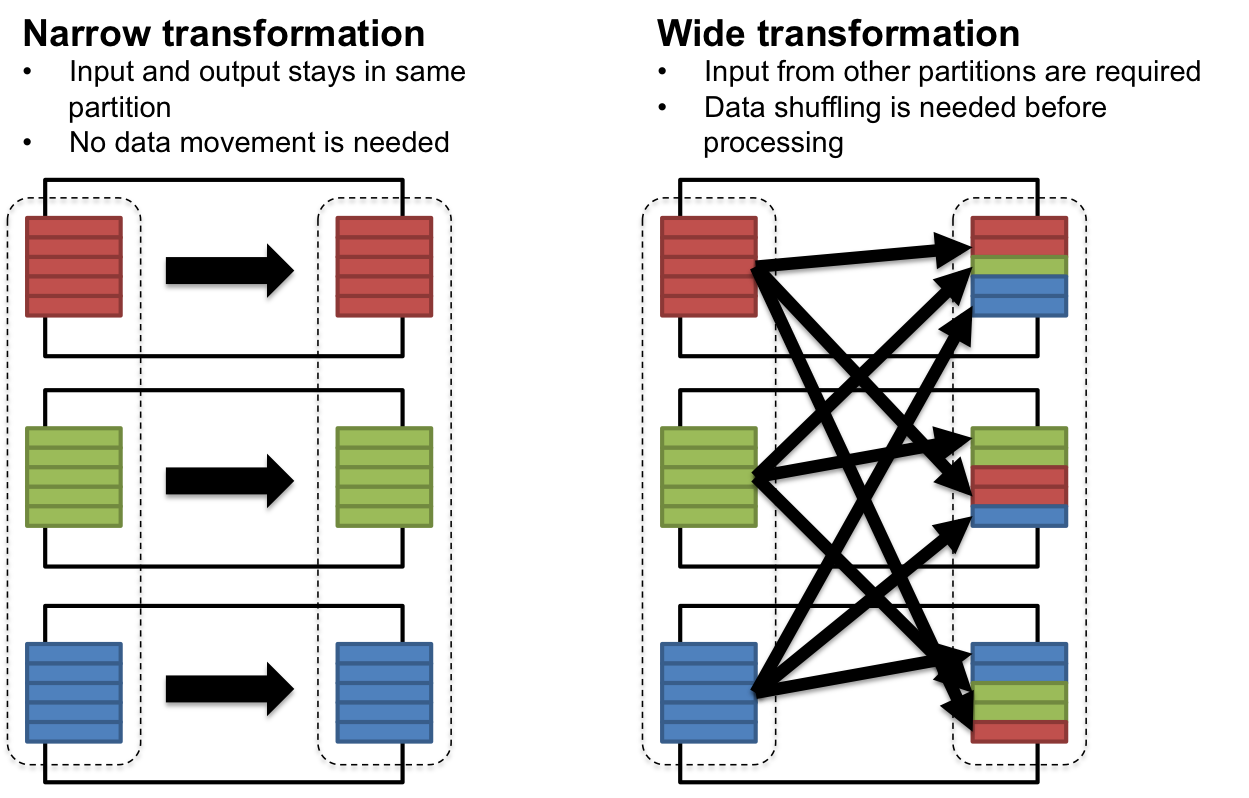

### Узкие трансформации

#### Map, flatMap

In [52]:
rdd5 = rdd4.map(lambda x: (x, x))

In [53]:
rdd5.take(5)

[(102, 102), (106, 106), (110, 110), (114, 114), (118, 118)]

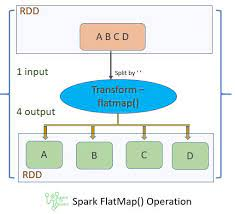

In [33]:
rdd5.flatMap(lambda x: x).take(10)

[102, 102, 106, 106, 110, 110, 114, 114, 118, 118]

#### Также к узким трансформациям будут относится такие операции как filter, union, sample

### Широкие трансформации: groupBy
* широкие преобразования приводят к образованию дополнительного **stage-а**

In [54]:
rdd4.take(5)

[102, 106, 110, 114, 118]

In [55]:
grouped_rdd = rdd4.groupBy(lambda x: x)

In [56]:
grouped_rdd.collect()

[(202, <pyspark.resultiterable.ResultIterable at 0xffff5b44c9d0>),
 (206, <pyspark.resultiterable.ResultIterable at 0xffff5b44efb0>),
 (210, <pyspark.resultiterable.ResultIterable at 0xffff5b44f340>),
 (214, <pyspark.resultiterable.ResultIterable at 0xffff5b44f160>),
 (218, <pyspark.resultiterable.ResultIterable at 0xffff5b44d990>),
 (222, <pyspark.resultiterable.ResultIterable at 0xffff5b44ec80>),
 (226, <pyspark.resultiterable.ResultIterable at 0xffff5b44dba0>),
 (230, <pyspark.resultiterable.ResultIterable at 0xffff5b44c820>),
 (234, <pyspark.resultiterable.ResultIterable at 0xffff5b44e6b0>),
 (238, <pyspark.resultiterable.ResultIterable at 0xffff5b44da80>),
 (242, <pyspark.resultiterable.ResultIterable at 0xffff5b44d5d0>),
 (246, <pyspark.resultiterable.ResultIterable at 0xffff5b44c610>),
 (250, <pyspark.resultiterable.ResultIterable at 0xffff5b44f430>),
 (254, <pyspark.resultiterable.ResultIterable at 0xffff5b44c430>),
 (258, <pyspark.resultiterable.ResultIterable at 0xffff5b44e71

#### Количество партиций в новом rdd после широкой трансформации может быть отлично от количества партиций в родительском rdd 

In [ ]:
"spark.default.parallelizm"

In [57]:
grouped_rdd.map(lambda x: (x[0], len(x[1]))).take(5)

[(102, 1), (106, 1), (110, 1), (114, 1), (118, 1)]

## Вычисления в спарке состоят из 3х состовляющих:
* Job - триггер вычисления графа вычислений по action-у)
* Stage - вычисление одной широкой трансформации
* * Чем больше широких трансформаций, тем больше стейджей и тем больше пересылок данных между экзеками
* Task - вычисление трансформаций над одной партицией в данных
* * Соответственно, чем больше партиций, тем больше тасков для наших экзекьюторов, что иногда очень хорошо
 
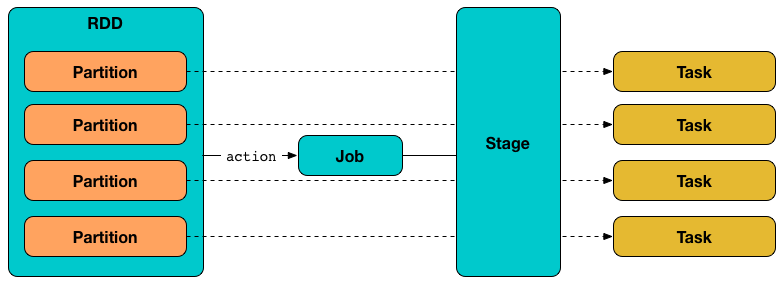

# Word count над rdd

In [58]:
tags = sc.textFile("ml-latest-small/tags.csv")

In [59]:
tags.take(10)

['userId,movieId,tag,timestamp',
 '2,60756,funny,1445714994',
 '2,60756,Highly quotable,1445714996',
 '2,60756,will ferrell,1445714992',
 '2,89774,Boxing story,1445715207',
 '2,89774,MMA,1445715200',
 '2,89774,Tom Hardy,1445715205',
 '2,106782,drugs,1445715054',
 '2,106782,Leonardo DiCaprio,1445715051',
 '2,106782,Martin Scorsese,1445715056']

In [60]:
tags_content = tags.filter(lambda x: "userId" not in x)

In [61]:
tags_content.take(5)

['2,60756,funny,1445714994',
 '2,60756,Highly quotable,1445714996',
 '2,60756,will ferrell,1445714992',
 '2,89774,Boxing story,1445715207',
 '2,89774,MMA,1445715200']

In [62]:
tags_splitted = tags_content.map(lambda x: x.split(","))

In [63]:
tags_splitted.take(10)

[['2', '60756', 'funny', '1445714994'],
 ['2', '60756', 'Highly quotable', '1445714996'],
 ['2', '60756', 'will ferrell', '1445714992'],
 ['2', '89774', 'Boxing story', '1445715207'],
 ['2', '89774', 'MMA', '1445715200'],
 ['2', '89774', 'Tom Hardy', '1445715205'],
 ['2', '106782', 'drugs', '1445715054'],
 ['2', '106782', 'Leonardo DiCaprio', '1445715051'],
 ['2', '106782', 'Martin Scorsese', '1445715056'],
 ['7', '48516', 'way too long', '1169687325']]

In [64]:
tags_words = tags_splitted.map(lambda x: x[2])

In [65]:
tags_words.take(10)

['funny',
 'Highly quotable',
 'will ferrell',
 'Boxing story',
 'MMA',
 'Tom Hardy',
 'drugs',
 'Leonardo DiCaprio',
 'Martin Scorsese',
 'way too long']

In [66]:
tags_words_splitted = tags_words.map(lambda x: x.split(" "))

In [67]:
tags_words_splitted.take(10)

[['funny'],
 ['Highly', 'quotable'],
 ['will', 'ferrell'],
 ['Boxing', 'story'],
 ['MMA'],
 ['Tom', 'Hardy'],
 ['drugs'],
 ['Leonardo', 'DiCaprio'],
 ['Martin', 'Scorsese'],
 ['way', 'too', 'long']]

In [68]:
words = tags_words_splitted.flatMap(lambda x: x)

In [69]:
words.take(10)

['funny',
 'Highly',
 'quotable',
 'will',
 'ferrell',
 'Boxing',
 'story',
 'MMA',
 'Tom',
 'Hardy']

In [70]:
words.groupBy(lambda x: x).map(lambda x: (x[0], len(x[1]))).take(10)

[('superhero', 25),
 ('martial', 8),
 ('business', 20),
 ('stand-up', 1),
 ('comedy', 60),
 ('writing', 7),
 ('Wharton', 2),
 ('pageant', 1),
 ('bluegrass', 1),
 ('movies', 6)]

In [71]:
words.map(lambda x: (x, 1)).countByKey()

defaultdict(int,
            {'funny': 27,
             'Highly': 3,
             'quotable': 4,
             'will': 4,
             'ferrell': 4,
             'Boxing': 1,
             'story': 15,
             'MMA': 1,
             'Tom': 8,
             'Hardy': 2,
             'drugs': 11,
             'Leonardo': 10,
             'DiCaprio': 10,
             'Martin': 4,
             'Scorsese': 4,
             'way': 1,
             'too': 5,
             'long': 6,
             'Al': 5,
             'Pacino': 5,
             'gangster': 3,
             'mafia': 3,
             'Mafia': 10,
             'holocaust': 2,
             'true': 8,
             'twist': 23,
             'ending': 29,
             'Anthony': 1,
             'Hopkins': 1,
             'courtroom': 2,
             'drama': 6,
             'britpop': 1,
             'indie': 1,
             'record': 1,
             'label': 1,
             'music': 22,
             'dumpster': 1,
             'diving': 

In [72]:
words.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).take(10)

[('quotable', 4),
 ('Boxing', 1),
 ('story', 15),
 ('Tom', 8),
 ('Hardy', 2),
 ('Leonardo', 10),
 ('DiCaprio', 10),
 ('Scorsese', 4),
 ('way', 1),
 ('long', 6)]

### Join двух RDD - еще одна широкая трансформация

In [73]:
ratings = sc.textFile("ml-latest-small/ratings.csv")

In [74]:
tags = sc.textFile("ml-latest-small/tags.csv")

In [75]:
ratings_parsed = ratings\
    .filter(lambda x: "userId" not in x)\
    .map(lambda x: x.split(","))

In [76]:
ratings_parsed.take(5)

[['1', '1', '4.0', '964982703'],
 ['1', '3', '4.0', '964981247'],
 ['1', '6', '4.0', '964982224'],
 ['1', '47', '5.0', '964983815'],
 ['1', '50', '5.0', '964982931']]

In [77]:
tags_parsed = tags\
    .filter(lambda x: "userId" not in x)\
    .map(lambda x: x.split(","))

In [58]:
tags_parsed.take(5)

[['2', '60756', 'funny', '1445714994'],
 ['2', '60756', 'Highly quotable', '1445714996'],
 ['2', '60756', 'will ferrell', '1445714992'],
 ['2', '89774', 'Boxing story', '1445715207'],
 ['2', '89774', 'MMA', '1445715200']]

In [78]:
# часть инфорации не подтянулась - плохо
ratings_parsed.join(tags_parsed).take(5)

[('112', ('1', '260')),
 ('112', ('1', '260')),
 ('112', ('1', '260')),
 ('112', ('2', '260')),
 ('112', ('2', '260'))]

In [79]:
# надо костылить
ratings_parsed_paired = ratings_parsed\
    .map(lambda x: (x[0], [x[1], x[2], x[3]]))

In [80]:
ratings_parsed_paired.take(5)

[('1', ['1', '4.0', '964982703']),
 ('1', ['3', '4.0', '964981247']),
 ('1', ['6', '4.0', '964982224']),
 ('1', ['47', '5.0', '964983815']),
 ('1', ['50', '5.0', '964982931'])]

In [81]:
# надо костылить
tags_parsed_paired = tags_parsed\
    .map(lambda x: (x[0], [x[1], x[2], x[3]]))

In [82]:
tags_parsed_paired.take(5)

[('2', ['60756', 'funny', '1445714994']),
 ('2', ['60756', 'Highly quotable', '1445714996']),
 ('2', ['60756', 'will ferrell', '1445714992']),
 ('2', ['89774', 'Boxing story', '1445715207']),
 ('2', ['89774', 'MMA', '1445715200'])]

In [83]:
# часть инфорации не подтянулась - плохо
ratings_parsed_paired.join(tags_parsed_paired).take(5)

[('112',
  (['1', '3.0', '1442535639'], ['260', 'classic sci-fi', '1442535682'])),
 ('112',
  (['1', '3.0', '1442535639'], ['260', 'engrossing adventure', '1442535673'])),
 ('112', (['1', '3.0', '1442535639'], ['260', 'EPIC', '1442535666'])),
 ('112',
  (['2', '1.5', '1513989948'], ['260', 'classic sci-fi', '1442535682'])),
 ('112',
  (['2', '1.5', '1513989948'], ['260', 'engrossing adventure', '1442535673']))]

In [65]:
# если хотим поджоинить на 2 ключа

In [84]:
ratings_parsed_paired_two_keys = ratings_parsed\
    .map(lambda x: ((x[0], x[1]), [x[2], x[3]]))    

In [85]:
ratings_parsed_paired_two_keys.take(5)

[(('1', '1'), ['4.0', '964982703']),
 (('1', '3'), ['4.0', '964981247']),
 (('1', '6'), ['4.0', '964982224']),
 (('1', '47'), ['5.0', '964983815']),
 (('1', '50'), ['5.0', '964982931'])]

In [86]:
tags_parsed_paired_two_keys = tags_parsed\
    .map(lambda x: ((x[0], x[1]), [x[2], x[3]]))

In [87]:
tags_parsed_paired_two_keys.take(5)

[(('2', '60756'), ['funny', '1445714994']),
 (('2', '60756'), ['Highly quotable', '1445714996']),
 (('2', '60756'), ['will ferrell', '1445714992']),
 (('2', '89774'), ['Boxing story', '1445715207']),
 (('2', '89774'), ['MMA', '1445715200'])]

In [88]:
joined_rdd = ratings_parsed_paired_two_keys.join(tags_parsed_paired_two_keys)

In [89]:
joined_rdd.take(5)

[(('2', '106782'), (['5.0', '1445714966'], ['drugs', '1445715054'])),
 (('2', '106782'),
  (['5.0', '1445714966'], ['Leonardo DiCaprio', '1445715051'])),
 (('2', '106782'), (['5.0', '1445714966'], ['Martin Scorsese', '1445715056'])),
 (('18', '44665'), (['4.5', '1455049870'], ['twist ending', '1456948283'])),
 (('18', '52604'), (['4.5', '1457650649'], ['Anthony Hopkins', '1457650696']))]

### Управление параллелизмом

#### repartition - меняет количество партиций (можно больше или меньше) и равномерно (насколько это возможно) размещает данные по партициям
#### также является широкой трансформацией

In [90]:
repartitioned_rdd = joined_rdd.repartition(100)

In [91]:
repartitioned_rdd.getNumPartitions()

100

In [92]:
repartitioned_rdd.collect()

[(('474', '3556'), (['4.0', '1115584884'], ['1970s', '1138032871'])),
 (('474', '3556'), (['4.0', '1115584884'], ['suicide', '1138032871'])),
 (('474', '3566'), (['4.5', '1081177351'], ['business', '1137205342'])),
 (('474', '3566'), (['4.5', '1081177351'], ['religion', '1137205342'])),
 (('474', '3683'), (['3.5', '1137521116'], ['Coen Brothers', '1137521124'])),
 (('474', '3712'), (['2.5', '1087832841'], ['television', '1137375317'])),
 (('474', '3723'), (['4.0', '979180620'], ['Shakespeare', '1137191908'])),
 (('474', '3811'), (['4.0', '1107444826'], ['court', '1138032584'])),
 (('474', '3816'),
  (['4.0', '1132195959'], ['missing children', '1138032720'])),
 (('474', '3844'), (['2.5', '1060104337'], ['diabetes', '1137375348'])),
 (('599', '2959'), (['5.0', '1498456882'], ['imdb top 250', '1498456941'])),
 (('599', '2959'), (['5.0', '1498456882'], ['mental illness', '1498456903'])),
 (('599', '2959'), (['5.0', '1498456882'], ['mind-blowing', '1498456955'])),
 (('599', '2959'), (['5.0

In [93]:
rdd10 = sc.parallelize(range(10))

In [95]:
rdd10.repartition(20).glom().collect()

[[],
 [],
 [],
 [],
 [5, 6, 7, 8, 9],
 [],
 [],
 [],
 [],
 [0, 1, 2, 3, 4],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

#### coalesce - меняет количество партиций только в меньшую сторону и размещает данные (не всегда равномерно) по партициям
#### в основном является узкой трансформацией, но иногда может быть широкой

In [96]:
rdd_coalesce = joined_rdd.coalesce(2)

In [97]:
joined_rdd.getNumPartitions()

4

In [98]:
rdd_coalesce.getNumPartitions()

2

In [99]:
rdd_coalesce.collect()

[(('336', '1'), (['4.0', '1122227329'], ['pixar', '1139045764'])),
 (('336', '37729'), (['2.5', '1139047287'], ['animation', '1139047294'])),
 (('356', '2146'), (['4.5', '1229142976'], ['post-college', '1229142995'])),
 (('356', '37384'), (['5.0', '1229142463'], ['restaurant', '1229142458'])),
 (('356', '61323'), (['5.0', '1228073421'], ['dark comedy', '1228073481'])),
 (('357', '39'), (['4.5', '1348612128'], ['chick flick', '1348627867'])),
 (('357', '39'), (['4.5', '1348612128'], ['funny', '1348627869'])),
 (('357', '39'), (['4.5', '1348612128'], ['Paul Rudd', '1348627871'])),
 (('357', '39'), (['4.5', '1348612128'], ['quotable', '1348627873'])),
 (('357', '39'),
  (['4.5', '1348612128'], ['seen more than once', '1348627878'])),
 (('357', '54997'), (['4.0', '1348611193'], ['Christian Bale', '1348627195'])),
 (('357', '91529'), (['4.5', '1348626808'], ['Anne Hathaway', '1348626758'])),
 (('357', '91529'), (['4.5', '1348626808'], ['Christian Bale', '1348626755'])),
 (('357', '91529'),


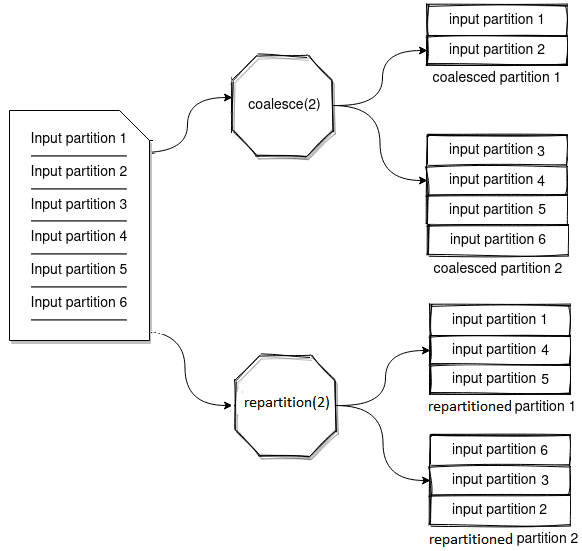

In [6]:
# при завершении работы с приложением останавливаем SparkContext
sc.stop()

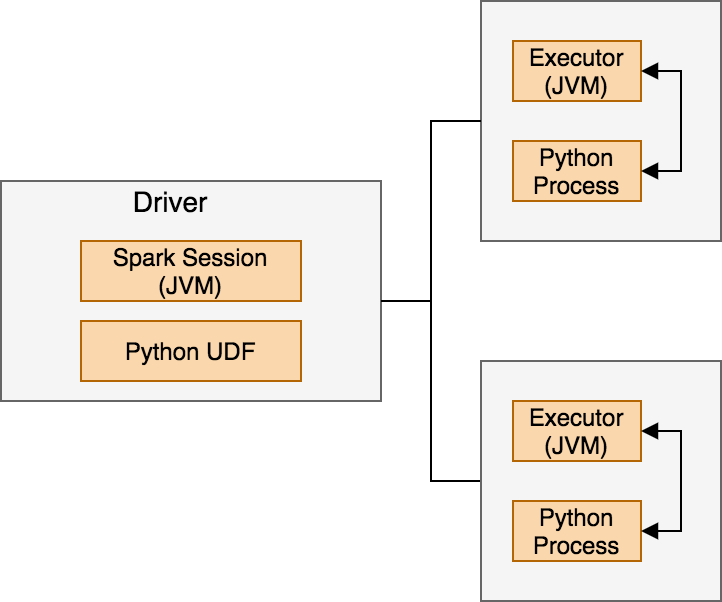

# DataFrame

In [7]:
from pyspark.sql import SparkSession

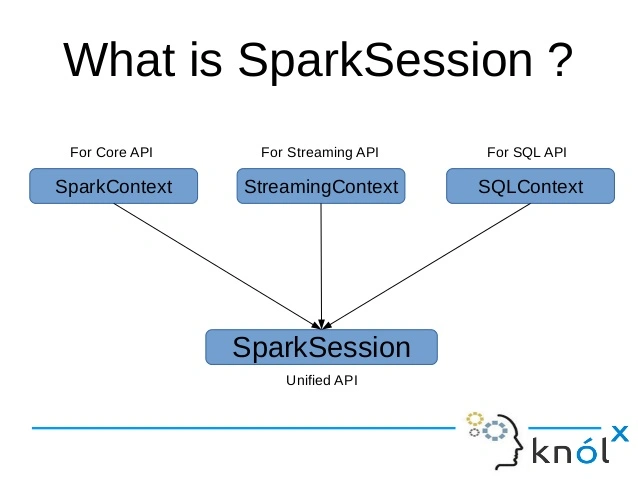

In [8]:
spark = SparkSession.builder.master("yarn").appName("pyspark_sql_api").getOrCreate()

23/11/30 15:15:08 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [104]:
spark

#### Очень много поддерживаемых типов данных
* json
* csv
* parquet
* kafka
* hive
* cassandra
* ...

In [12]:
%%time
ratings_df = spark.read.format("csv").option("header", "True").load("ml-latest-small/ratings.csv")

CPU times: user 6.46 ms, sys: 1.46 ms, total: 7.92 ms
Wall time: 3.09 s


In [13]:
ratings_df

DataFrame[userId: string, movieId: string, rating: string, timestamp: string]

In [14]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



#### нужно самому указать схему

In [15]:
from pyspark.sql.types import *

In [16]:
ratings_schema = StructType(fields=[
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("rating", DoubleType()),
    StructField("timestamp", LongType()),
])

In [17]:
%%time
ratings_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(ratings_schema)\
    .load("ml-latest-small/ratings.csv")

CPU times: user 4.78 ms, sys: 2.84 ms, total: 7.63 ms
Wall time: 65 ms


In [18]:
ratings_df

DataFrame[userId: int, movieId: int, rating: double, timestamp: bigint]

In [19]:
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)



In [20]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [21]:
ratings_df.summary().show()

23/11/30 15:16:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    25%|               177|            1199|               3.0|          1018535155|
|    50%|               325|            2991|               3.5|          1186086516|
|    75%|               477|            8092|               4.0|          1435993828|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+---------

#### Также создать DataFrame можно из RDD, pd.DataFrame или листа

In [22]:
sc = spark.sparkContext

In [23]:
rdd = sc.textFile("ml-latest-small/ratings.csv").map(lambda x: x.split(","))

In [24]:
rdd.take(10)

[['userId', 'movieId', 'rating', 'timestamp'],
 ['1', '1', '4.0', '964982703'],
 ['1', '3', '4.0', '964981247'],
 ['1', '6', '4.0', '964982224'],
 ['1', '47', '5.0', '964983815'],
 ['1', '50', '5.0', '964982931'],
 ['1', '70', '3.0', '964982400'],
 ['1', '101', '5.0', '964980868'],
 ['1', '110', '4.0', '964982176'],
 ['1', '151', '5.0', '964984041']]

In [25]:
rdd.toDF()

DataFrame[_1: string, _2: string, _3: string, _4: string]

In [26]:
ratings_df = spark.createDataFrame(rdd)

In [27]:
ratings_df.show(5)

+------+-------+------+---------+
|    _1|     _2|    _3|       _4|
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
+------+-------+------+---------+
only showing top 5 rows



In [28]:
ratings_df = spark.createDataFrame(rdd, schema=ratings_schema)

In [29]:
ratings_df.show(5)

23/11/30 15:16:50 WARN TaskSetManager: Lost task 0.0 in stage 10.0 (TID 9) (nodemanager1 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/session.py", line 1459, in prepare
    verify_func(obj)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2187, in verify
    verify_value(obj)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2160, in ver

Py4JJavaError: An error occurred while calling o164.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 10.0 failed 4 times, most recent failure: Lost task 0.3 in stage 10.0 (TID 12) (nodemanager1 executor 2): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/session.py", line 1459, in prepare
    verify_func(obj)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2187, in verify
    verify_value(obj)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2160, in verify_struct
    verifier(v)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2187, in verify
    verify_value(obj)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2076, in verify_integer
    verify_acceptable_types(obj)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2006, in verify_acceptable_types
    raise PySparkTypeError(
pyspark.errors.exceptions.base.PySparkTypeError: [CANNOT_ACCEPT_OBJECT_IN_TYPE] `IntegerType()` can not accept object `userId` in type `str`.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4344)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3326)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3326)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3549)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/session.py", line 1459, in prepare
    verify_func(obj)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2187, in verify
    verify_value(obj)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2160, in verify_struct
    verifier(v)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2187, in verify
    verify_value(obj)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2076, in verify_integer
    verify_acceptable_types(obj)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/sql/types.py", line 2006, in verify_acceptable_types
    raise PySparkTypeError(
pyspark.errors.exceptions.base.PySparkTypeError: [CANNOT_ACCEPT_OBJECT_IN_TYPE] `IntegerType()` can not accept object `userId` in type `str`.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [30]:
rdd1 = rdd.map(lambda x: (int(x[0]), int(x[1], float(x[2]), int(x[3]))))

In [31]:
rdd1.take(5)

23/11/30 15:16:54 WARN TaskSetManager: Lost task 0.0 in stage 11.0 (TID 13) (nodemanager1 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/rdd.py", line 2849, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_20/120915169.py", line 1, in <lambda>
ValueError: invalid literal for int() with base 10: 'userId'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePyth

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 11.0 failed 4 times, most recent failure: Lost task 0.3 in stage 11.0 (TID 16) (nodemanager1 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/rdd.py", line 2849, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_20/120915169.py", line 1, in <lambda>
ValueError: invalid literal for int() with base 10: 'userId'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:181)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/rdd.py", line 2849, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_20/120915169.py", line 1, in <lambda>
ValueError: invalid literal for int() with base 10: 'userId'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:181)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [32]:
rdd2 = rdd.filter(lambda x: "userId" not in x)

In [33]:
rdd2.take(10)

[['1', '1', '4.0', '964982703'],
 ['1', '3', '4.0', '964981247'],
 ['1', '6', '4.0', '964982224'],
 ['1', '47', '5.0', '964983815'],
 ['1', '50', '5.0', '964982931'],
 ['1', '70', '3.0', '964982400'],
 ['1', '101', '5.0', '964980868'],
 ['1', '110', '4.0', '964982176'],
 ['1', '151', '5.0', '964984041'],
 ['1', '157', '5.0', '964984100']]

In [34]:
rdd3 = rdd2.map(lambda x: (int(x[0]), int(x[1]), float(x[2]), int(x[3])))

In [35]:
rdd3.take(5)

[(1, 1, 4.0, 964982703),
 (1, 3, 4.0, 964981247),
 (1, 6, 4.0, 964982224),
 (1, 47, 5.0, 964983815),
 (1, 50, 5.0, 964982931)]

In [36]:
ratings_df = spark.createDataFrame(rdd3, schema=ratings_schema)

In [37]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [38]:
ratings_df.rdd.take(5)

[Row(userId=1, movieId=1, rating=4.0, timestamp=964982703),
 Row(userId=1, movieId=3, rating=4.0, timestamp=964981247),
 Row(userId=1, movieId=6, rating=4.0, timestamp=964982224),
 Row(userId=1, movieId=47, rating=5.0, timestamp=964983815),
 Row(userId=1, movieId=50, rating=5.0, timestamp=964982931)]

## Dataframe API:
* actions (collect, show, count, write, ...)
* transformation (projection (select), fitering, groupBy, join, ...)

#### Projection

In [39]:
ratings_df.select("userId", "movieId").show()

+------+-------+
|userId|movieId|
+------+-------+
|     1|      1|
|     1|      3|
|     1|      6|
|     1|     47|
|     1|     50|
|     1|     70|
|     1|    101|
|     1|    110|
|     1|    151|
|     1|    157|
|     1|    163|
|     1|    216|
|     1|    223|
|     1|    231|
|     1|    235|
|     1|    260|
|     1|    296|
|     1|    316|
|     1|    333|
|     1|    349|
+------+-------+
only showing top 20 rows



In [40]:
ratings_df.select(ratings_df.columns[:3]).show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



#### Aliasing

In [41]:
# так как алиасить строчку не получится, алиасить нужно "столбец", у которого есть соответствующие атрибуты и методы
ratings_df.select(ratings_df.userId, ratings_df.movieId.alias("movie")).show()

+------+-----+
|userId|movie|
+------+-----+
|     1|    1|
|     1|    3|
|     1|    6|
|     1|   47|
|     1|   50|
|     1|   70|
|     1|  101|
|     1|  110|
|     1|  151|
|     1|  157|
|     1|  163|
|     1|  216|
|     1|  223|
|     1|  231|
|     1|  235|
|     1|  260|
|     1|  296|
|     1|  316|
|     1|  333|
|     1|  349|
+------+-----+
only showing top 20 rows



In [42]:
ratings_df.userId

Column<'userId'>

In [43]:
import pyspark.sql.functions as f

In [44]:
ratings_df.select(f.col("userId"), f.col("movieId").alias("movie")).show()

+------+-----+
|userId|movie|
+------+-----+
|     1|    1|
|     1|    3|
|     1|    6|
|     1|   47|
|     1|   50|
|     1|   70|
|     1|  101|
|     1|  110|
|     1|  151|
|     1|  157|
|     1|  163|
|     1|  216|
|     1|  223|
|     1|  231|
|     1|  235|
|     1|  260|
|     1|  296|
|     1|  316|
|     1|  333|
|     1|  349|
+------+-----+
only showing top 20 rows



#### filtering

In [45]:
ratings_df.filter((f.col("movieId") == 1) &  (f.col("userId") == 1)).show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
+------+-------+------+---------+



### Functions:
* mapping (one-to-one)
* aggregation (many-to-one) (group by)
* generation (one-to-many) (explode)

#### Mappings - narrow transformation

In [46]:
ratings_df.select("userId", f.from_unixtime("timestamp").alias("timestamp_from_unix")).show()

+------+-------------------+
|userId|timestamp_from_unix|
+------+-------------------+
|     1|2000-07-30 22:45:03|
|     1|2000-07-30 22:20:47|
|     1|2000-07-30 22:37:04|
|     1|2000-07-30 23:03:35|
|     1|2000-07-30 22:48:51|
|     1|2000-07-30 22:40:00|
|     1|2000-07-30 22:14:28|
|     1|2000-07-30 22:36:16|
|     1|2000-07-30 23:07:21|
|     1|2000-07-30 23:08:20|
|     1|2000-07-30 23:00:50|
|     1|2000-07-30 22:20:08|
|     1|2000-07-30 22:16:25|
|     1|2000-07-30 22:19:39|
|     1|2000-07-30 22:15:08|
|     1|2000-07-30 22:28:00|
|     1|2000-07-30 22:49:27|
|     1|2000-07-30 22:38:30|
|     1|2000-07-30 22:19:39|
|     1|2000-07-30 22:42:43|
+------+-------------------+
only showing top 20 rows



In [47]:
ratings_df.select("userId", f.from_unixtime(f.lit(60*60) + f.col("timestamp")).alias("timestamp_from_unix_shifted")).show()

+------+---------------------------+
|userId|timestamp_from_unix_shifted|
+------+---------------------------+
|     1|        2000-07-30 23:45:03|
|     1|        2000-07-30 23:20:47|
|     1|        2000-07-30 23:37:04|
|     1|        2000-07-31 00:03:35|
|     1|        2000-07-30 23:48:51|
|     1|        2000-07-30 23:40:00|
|     1|        2000-07-30 23:14:28|
|     1|        2000-07-30 23:36:16|
|     1|        2000-07-31 00:07:21|
|     1|        2000-07-31 00:08:20|
|     1|        2000-07-31 00:00:50|
|     1|        2000-07-30 23:20:08|
|     1|        2000-07-30 23:16:25|
|     1|        2000-07-30 23:19:39|
|     1|        2000-07-30 23:15:08|
|     1|        2000-07-30 23:28:00|
|     1|        2000-07-30 23:49:27|
|     1|        2000-07-30 23:38:30|
|     1|        2000-07-30 23:19:39|
|     1|        2000-07-30 23:42:43|
+------+---------------------------+
only showing top 20 rows



#### Aggregation - wide transformation

In [48]:
ratings_df\
    .groupBy(f.col("userId"))\
    .count()\
    .show()

+------+-----+
|userId|count|
+------+-----+
|   148|   48|
|   243|   36|
|    31|   50|
|    85|   34|
|   137|  141|
|   251|   23|
|    65|   34|
|    53|   20|
|   255|   44|
|   133|   35|
|   296|   27|
|    78|   61|
|   322|  107|
|   321|   56|
|   108|   76|
|   155|   46|
|    34|   86|
|   193|   35|
|   211|   89|
|   101|   61|
+------+-----+
only showing top 20 rows



In [49]:
ratings_df\
    .groupBy(f.col("userId"))\
    .agg(f.avg(f.col("rating")).alias("avg_rating"))\
    .show()

+------+------------------+
|userId|        avg_rating|
+------+------------------+
|   148|3.7395833333333335|
|   243| 4.138888888888889|
|    31|              3.92|
|    85|3.7058823529411766|
|   137| 3.978723404255319|
|   251| 4.869565217391305|
|    65| 4.029411764705882|
|    53|               5.0|
|   255|2.5681818181818183|
|   133|               3.0|
|   296| 4.166666666666667|
|    78|3.1639344262295084|
|   322| 3.411214953271028|
|   321|3.5714285714285716|
|   108| 3.986842105263158|
|   155| 3.608695652173913|
|    34|3.4186046511627906|
|   193|               3.8|
|   211| 3.904494382022472|
|   101| 3.557377049180328|
+------+------------------+
only showing top 20 rows



### Generation (explode - narrow transformation)

In [50]:
ratings_list = ratings_df\
    .groupBy(f.col("userId"))\
    .agg(f.collect_list(f.col("rating")).alias("ratings"))

In [51]:
ratings_list.show()

+------+--------------------+
|userId|             ratings|
+------+--------------------+
|     1|[4.0, 4.0, 4.0, 5...|
|     2|[3.0, 4.0, 4.5, 4...|
|     3|[0.5, 0.5, 0.5, 0...|
|     4|[3.0, 2.0, 3.0, 2...|
|     5|[4.0, 4.0, 4.0, 4...|
|     6|[4.0, 5.0, 3.0, 5...|
|     7|[4.5, 4.5, 3.0, 4...|
|     8|[4.0, 2.0, 4.0, 4...|
|     9|[3.0, 3.0, 4.0, 3...|
|    10|[1.0, 3.5, 4.0, 3...|
|    11|[5.0, 3.0, 4.0, 2...|
|    12|[4.0, 5.0, 5.0, 5...|
|    13|[5.0, 1.0, 3.0, 3...|
|    14|[3.0, 3.0, 1.0, 4...|
|    15|[2.5, 1.0, 3.5, 1...|
|    16|[3.5, 4.0, 4.5, 2...|
|    17|[4.5, 3.5, 4.0, 4...|
|    18|[3.5, 3.0, 4.0, 4...|
|    19|[4.0, 3.0, 3.0, 2...|
|    20|[3.0, 1.0, 4.0, 4...|
+------+--------------------+
only showing top 20 rows



In [52]:
ratings_list.select("userId", f.explode(f.col("ratings"))).show()

+------+---+
|userId|col|
+------+---+
|     1|4.0|
|     1|4.0|
|     1|4.0|
|     1|5.0|
|     1|5.0|
|     1|3.0|
|     1|5.0|
|     1|4.0|
|     1|5.0|
|     1|5.0|
|     1|5.0|
|     1|5.0|
|     1|3.0|
|     1|5.0|
|     1|4.0|
|     1|5.0|
|     1|3.0|
|     1|3.0|
|     1|5.0|
|     1|4.0|
+------+---+
only showing top 20 rows



## toPandas

In [53]:
# никогда не делайте toPandas всего датафрейма (если он не влезает в память драйвера)
ratings_list\
    .toPandas()

,userId,ratings
0,1,"[4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, ..."
1,2,"[3.0, 4.0, 4.5, 4.0, 4.0, 3.5, 4.0, 4.0, 4.5, ..."
2,3,"[0.5, 0.5, 0.5, 0.5, 0.5, 5.0, 0.5, 0.5, 0.5, ..."
3,4,"[3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 4.0, 5.0, 1.0, ..."
4,5,"[4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ..."
...,...,...
605,606,"[2.5, 2.5, 2.5, 3.5, 4.0, 4.0, 2.0, 3.5, 4.5, ..."
606,607,"[4.0, 3.0, 3.0, 3.0, 4.0, 4.0, 5.0, 2.0, 5.0, ..."
607,608,"[2.5, 2.0, 2.0, 4.0, 4.5, 2.0, 3.5, 2.0, 3.0, ..."
608,609,"[3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ..."


## Hello world! (word count)

In [54]:
tags_schema = StructType([
    StructField("userId", IntegerType(), True), 
    StructField("movieId", IntegerType(), True), 
    StructField("tag", StringType(), True), 
    StructField("timestamp", LongType(), True)])

In [55]:
tags_df = spark.read.csv("ml-latest-small/tags.csv", header=True, schema=tags_schema)

In [56]:
tags_df.show()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
|    18|    431|        Al Pacino|1462138765|
|    18|    431|         gangster|1462138749|
|    18|    431|            mafia|1462138755|
|    18|   1221|        Al Pacino|1461699306|
|    18|   1221|            Mafia|1461699303|
|    18|   5995|        holocaust|1455735472|
|    18|   5995|       true story|1455735479|
|    18|  44665|     twist ending|1456948283|
|    18|  52604|  Anthony Hopkins|

In [57]:
tags_df

DataFrame[userId: int, movieId: int, tag: string, timestamp: bigint]

In [58]:
tags_df\
    .select(f.split("tag", " ").alias("word_list"))\
    .select(f.explode("word_list").alias("word"))\
    .groupBy("word")\
    .count()\
    .orderBy("count", ascending=False)\
    .show()

+-----------------+-----+
|             word|count|
+-----------------+-----+
|          Netflix|  134|
|               In|  132|
|            queue|  131|
|           comedy|   60|
|             dark|   46|
|      atmospheric|   36|
|              and|   32|
|           ending|   29|
|            space|   27|
|            funny|   27|
|            crime|   26|
|              bad|   25|
|        superhero|   25|
|           sci-fi|   25|
|           Disney|   24|
|thought-provoking|   24|
|         visually|   23|
|          surreal|   23|
|            twist|   23|
|            music|   22|
+-----------------+-----+
only showing top 20 rows



In [59]:
ratings_with_tags_df = ratings_df.join(tags_df, on=["userId", "movieId"], how="inner")

In [60]:
ratings_with_tags_df.show()

+------+-------+------+----------+-----------------+----------+
|userId|movieId|rating| timestamp|              tag| timestamp|
+------+-------+------+----------+-----------------+----------+
|     2|  60756|   5.0|1445714980|     will ferrell|1445714992|
|     2|  60756|   5.0|1445714980|  Highly quotable|1445714996|
|     2|  60756|   5.0|1445714980|            funny|1445714994|
|     2|  89774|   5.0|1445715189|        Tom Hardy|1445715205|
|     2|  89774|   5.0|1445715189|              MMA|1445715200|
|     2|  89774|   5.0|1445715189|     Boxing story|1445715207|
|     2| 106782|   5.0|1445714966|  Martin Scorsese|1445715056|
|     2| 106782|   5.0|1445714966|Leonardo DiCaprio|1445715051|
|     2| 106782|   5.0|1445714966|            drugs|1445715054|
|     7|  48516|   1.0|1169687318|     way too long|1169687325|
|    18|    431|   4.0|1462138790|            mafia|1462138755|
|    18|    431|   4.0|1462138790|         gangster|1462138749|
|    18|    431|   4.0|1462138790|      

In [64]:
ratings_with_tags_df.select("timestamp")

AnalysisException: [AMBIGUOUS_REFERENCE] Reference `timestamp` is ambiguous, could be: [`r`.`timestamp`, `t`.`timestamp`].

In [65]:
ratings_with_tags_df = ratings_df.alias("r").join(tags_df.alias("t"), on=["userId", "movieId"], how="inner")

In [66]:
ratings_with_tags_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: long (nullable = true)



In [67]:
ratings_with_tags_df.select("r.timestamp", "t.timestamp").show()

+----------+----------+
| timestamp| timestamp|
+----------+----------+
|1445714980|1445714992|
|1445714980|1445714996|
|1445714980|1445714994|
|1445715189|1445715205|
|1445715189|1445715200|
|1445715189|1445715207|
|1445714966|1445715056|
|1445714966|1445715051|
|1445714966|1445715054|
|1169687318|1169687325|
|1462138790|1462138755|
|1462138790|1462138749|
|1462138790|1462138765|
|1460242083|1461699303|
|1460242083|1461699306|
|1455735416|1455735479|
|1455735416|1455735472|
|1455049870|1456948283|
|1457650649|1457650682|
|1457650649|1457650711|
+----------+----------+
only showing top 20 rows



### Оконные функции

In [68]:
from pyspark.sql.window import Window

* count, max, min, sum, avg
* row_number
* lag, lead
* rank
* ntile

In [69]:
ratings_with_tags_df.show()

+------+-------+------+----------+-----------------+----------+
|userId|movieId|rating| timestamp|              tag| timestamp|
+------+-------+------+----------+-----------------+----------+
|     2|  60756|   5.0|1445714980|     will ferrell|1445714992|
|     2|  60756|   5.0|1445714980|  Highly quotable|1445714996|
|     2|  60756|   5.0|1445714980|            funny|1445714994|
|     2|  89774|   5.0|1445715189|        Tom Hardy|1445715205|
|     2|  89774|   5.0|1445715189|              MMA|1445715200|
|     2|  89774|   5.0|1445715189|     Boxing story|1445715207|
|     2| 106782|   5.0|1445714966|  Martin Scorsese|1445715056|
|     2| 106782|   5.0|1445714966|Leonardo DiCaprio|1445715051|
|     2| 106782|   5.0|1445714966|            drugs|1445715054|
|     7|  48516|   1.0|1169687318|     way too long|1169687325|
|    18|    431|   4.0|1462138790|            mafia|1462138755|
|    18|    431|   4.0|1462138790|         gangster|1462138749|
|    18|    431|   4.0|1462138790|      

In [70]:
# хотим получить предыдущую оценку
ratings_with_tags_with_prev_rating = ratings_with_tags_df\
    .withColumn("prev_rating", f.lag("rating").over(Window().partitionBy("userId").orderBy("r.timestamp")))

In [71]:
ratings_with_tags_with_prev_rating.show()

+------+-------+------+----------+------------------+----------+-----------+
|userId|movieId|rating| timestamp|               tag| timestamp|prev_rating|
+------+-------+------+----------+------------------+----------+-----------+
|     2| 106782|   5.0|1445714966|   Martin Scorsese|1445715056|       NULL|
|     2| 106782|   5.0|1445714966| Leonardo DiCaprio|1445715051|        5.0|
|     2| 106782|   5.0|1445714966|             drugs|1445715054|        5.0|
|     2|  60756|   5.0|1445714980|      will ferrell|1445714992|        5.0|
|     2|  60756|   5.0|1445714980|   Highly quotable|1445714996|        5.0|
|     2|  60756|   5.0|1445714980|             funny|1445714994|        5.0|
|     2|  89774|   5.0|1445715189|         Tom Hardy|1445715205|        5.0|
|     2|  89774|   5.0|1445715189|               MMA|1445715200|        5.0|
|     2|  89774|   5.0|1445715189|      Boxing story|1445715207|        5.0|
|     7|  48516|   1.0|1169687318|      way too long|1169687325|       NULL|

## Управление параллелизмом

In [72]:
ratings_with_tags_with_prev_rating.rdd.getNumPartitions()

1

In [73]:
df_repartition = ratings_with_tags_with_prev_rating.repartition(10)

In [74]:
df_repartition.rdd.getNumPartitions()

10

In [75]:
df_coalesce = df_repartition.coalesce(5)

In [76]:
df_coalesce.rdd.getNumPartitions()

5

In [77]:
spark.stop()

# Выводы:
* Спарк можно запускать с ярном, а можно локально (мы будем запускать с ярном)
* Есть spark UI, где можно помониторить всю инфо о джобах, стейджах, тасках, экзекьюторах и sql
* Есть RDD и DataFrame (в контексте питона предпочтителен именно DataFrame, так как в этом случае нет почти никакого оверхэда на перфоманс)
* В спарке есть ленивые трансформации и экшены
* Вычисления состоят из джоб, стейджей(чем больше широких трансформаций тем больше стейджей и тем больше шифл) и тасок (количества обработанных партиций)
* Единицей параллелизма является партиция - над ними экзекьюторы делают вычисления

In [78]:
spark = SparkSession.builder.appName("pyspark_sql_api").getOrCreate()

In [79]:
spark